# Introduction

This notebook presents a benchmark comparison between `power-grid-model` and 
[`pandapower`](https://github.com/e2nIEE/pandapower).
It runs several calculations, measures the calculation time, and compares the results.

## Test Network

The test network is fictionally generated using pre-defined random criteria. It is a radial network as follows:

```

source --- source_node ---| ---line--- node ---line--- node ...   (n_node_per_feeder)
                          |              |              |
                          |            load            load ...
                          |
                          | ---line--- ...
                          | .
                          | .
                          | .
                          | (n_feeder)

```

There is a node which is connected to a source (external network). From the source node there are `n_feeder` feeders. For each feeder there are `n_node_per_feeder` nodes, lines, and asymmetric loads. There are in total `n_feeder * n_node_per_feeder + 1` nodes in the network.


## Calculation

The notebook runs a power flow calculation with the same input data in `power-grid-model` and `pandapower`. It runs the following calculations:

* Single calculation with solver initialization.
* Single calculation without solver initialization (using pre-cached internal matrices).
* Time-series calculation
* N-1 calculation

The calculation is run symmetrically and asymmetrically. Both `power-grid-model` and `pandapower` supports asymmetric loads in symmetric calculations: the three-phase load is aggregated into one symmetric load.

We use the Newton-Raphson method for both libraries. In addition, we also use the linear method in `power-grid-model` to see how much performance you can gain in exchange for accuracy.

## Results Comparison

The following results are compared between `power-grid-model` and `pandapower`:

* Per unit voltage of nodes (buses). For asymmetric calculation, it compares the value per phase.
* Loading of the lines.

It only compares the results of the Newton-Raphson method, since the linear method of `power-grid-model` will produce a less accurate result.

## Performance Benchmark

The CPU time is measured for the **calculation part** of the program. The data preparation and model initialization is not measured. Furthermore, the single calculation is benchmarked with and without solver initialization. The former needs to execute connectivity check and initialize internal matrices (for example node admittance matrix). The latter uses the pre-cached connectivity and internal matrices.

# Preparation

## Import Libraries

We import neede libraries here. The fictional network generation and time-series profile generation is in a different Python file
[generate_fictional_dataset.py](./generate_fictional_dataset.py).

In [1]:
import tempfile
import time
from pathlib import Path

import numpy as np
import pandapower as pp
import pandas as pd
import power_grid_model as pgm
import Visualization
import matplotlib.pyplot as plt

from generate_fictional_dataset import generate_fictional_grid, generate_time_series

# output dir for pandapower time-series
output_dir = Path(tempfile.gettempdir()) / "pandapower_time_series"
output_dir.mkdir(exist_ok=True)


## Simulation Parameters

The simulation parameters, for example, the total number of feeders `n_feeder`, are defined below.

In [2]:
# grid parameters

n_node_per_feeder = 10
n_feeder_min = 100
n_feeder_max = 5000
interval = 100

# Input nodes selected equally spaced on a logarithmic scale
n_feeder_node_list = np.geomspace(n_feeder_min, n_feeder_max, num=10)
n_feeder_node_list = [int(value) for value in n_feeder_node_list]
n_node_list = [i * n_node_per_feeder for i in n_feeder_node_list]

cable_length_km_min = 0.8
cable_length_km_max = 1.2
load_p_w_max = 0.4e6 * 0.8
load_p_w_min = 0.4e6 * 1.2
pf = 0.95

load_scaling_min = 0.5
load_scaling_max = 1.5
n_step = 1000




## Prepare Data storage variables

The performance comparison variables is initialized below.

In [3]:
PGM_Linear_Symmetric_calculation_with_solver_initialization = [0]*len(n_feeder_node_list)
PGM_Linear_Symmetric_calculation_without_solver_initialization = [0]*len(n_feeder_node_list)
PGM_Linear_Asymmetric_calculation_with_solver_initialization = [0]*len(n_feeder_node_list)
PGM_Linear_Asymmetric_calculation_without_solver_initialization = [0]*len(n_feeder_node_list)
PGM_Linear_Time_series_symmetric_calculation = [0]*len(n_feeder_node_list)
PGM_Linear_Time_series_asymmetric_calculation = [0]*len(n_feeder_node_list)
PGM_Linear_N_1_symmetric_calculation = [0]*len(n_feeder_node_list)
PGM_Linear_N_1_asymmetric_calculation = [0]*len(n_feeder_node_list)

PGM_NR_Symmetric_calculation_with_solver_initialization = [0]*len(n_feeder_node_list)
PGM_NR_Symmetric_calculation_without_solver_initialization = [0]*len(n_feeder_node_list)
PGM_NR_Asymmetric_calculation_with_solver_initialization = [0]*len(n_feeder_node_list)
PGM_NR_Asymmetric_calculation_without_solver_initialization = [0]*len(n_feeder_node_list)
PGM_NR_Time_series_symmetric_calculation = [0]*len(n_feeder_node_list)
PGM_NR_Time_series_asymmetric_calculation = [0]*len(n_feeder_node_list)
PGM_NR_N_1_symmetric_calculation = [0]*len(n_feeder_node_list)
PGM_NR_N_1_asymmetric_calculation = [0]*len(n_feeder_node_list)

PandaPower_NR_Symmetric_calculation_with_solver_initialization = [0]*len(n_feeder_node_list)
PandaPower_NR_Symmetric_calculation_without_solver_initialization = [0]*len(n_feeder_node_list)
PandaPower_NR_Asymmetric_calculation_with_solver_initialization = [0]*len(n_feeder_node_list)
PandaPower_NR_Asymmetric_calculation_without_solver_initialization = [0]*len(n_feeder_node_list)
PandaPower_NR_Time_series_symmetric_calculation = [0]*len(n_feeder_node_list)
PandaPower_NR_Time_series_asymmetric_calculation = [0]*len(n_feeder_node_list)
PandaPower_NR_N_1_symmetric_calculation = [0]*len(n_feeder_node_list)
PandaPower_NR_N_1_asymmetric_calculation = [0]*len(n_feeder_node_list)

# Initialize Deviation Table

In [4]:
comparison_df = pd.DataFrame(
    np.zeros(shape=(6, 2), dtype=np.float64),
    columns=['Deviation Voltage (p.u.)', 'Deviation Loading (p.u.)'],
    index=[
        'Symmetric calculation',
        'Asymmetric calculation',
        'Time series symmetric calculation',
        'Time series asymmetric calculation',
        'N-1 symmetric calculation',
        'N-1 asymmetric calculation',
    ]
)

# Function call settings

In [5]:
Single_run =True
Time_series_run = False
N_1_run = False
Pandapower_run = True
use_lightsim2grid = True
Create_deviation_table = False

## Pre-cache Library

To make a fair comparison, we run one small network so that both `power-grid-model` and `pandapower` can cache their dependent libraries into the memory.

* For `power-grid-model` the `MKL` `PARDISO` solver is loaded during the pre-cache.
* For `pandapower` the `numba` functions are JIT compiled and cached in the memory.

In [6]:
fictional_dataset = generate_fictional_grid(
    n_node_per_feeder=3,
    n_feeder=2,
    cable_length_km_min=cable_length_km_min,
    cable_length_km_max=cable_length_km_max,
    load_p_w_max=load_p_w_max,
    load_p_w_min=load_p_w_min,
    pf=pf
)

pp.runpp(fictional_dataset['pp_net'], algorithm='nr', calculate_voltage_angles=True, distributed_slack=True,
         lightsim2grid=use_lightsim2grid)
pgm_model = pgm.PowerGridModel(fictional_dataset['pgm_dataset'])
pgm_result = pgm_model.calculate_power_flow()

# Single Calculation

In [7]:
if Single_run:

    for i in range(len(n_feeder_node_list)):
        n_feeder = n_feeder_node_list[i]
        
        # We begin with a single power flow calculation. First generate the fictional datasets.
        fictional_dataset = generate_fictional_grid(
            n_node_per_feeder=n_node_per_feeder,
            n_feeder=n_feeder,
            cable_length_km_min=cable_length_km_min,
            cable_length_km_max=cable_length_km_max,
            load_p_w_max=load_p_w_max,
            load_p_w_min=load_p_w_min,
            pf=pf
        )

        pp_net = fictional_dataset['pp_net']
        pgm_dataset = fictional_dataset['pgm_dataset']


        
# Symmetric

# Linear Method of power-grid-model



        # first calculation with solver initialization
        pgm_model = pgm.PowerGridModel(pgm_dataset)
        start = time.time()
        pgm_result = pgm_model.calculate_power_flow(calculation_method='linear')
        end = time.time()
        PGM_Linear_Symmetric_calculation_with_solver_initialization[i] = end - start
        #summary_df.loc['Symmetric calculation with solver initialization', 'PGM Linear'] = end - start

        # second calculation with existing solver
        start = time.time()
        pgm_result = pgm_model.calculate_power_flow(calculation_method='linear')
        end = time.time()
        PGM_Linear_Symmetric_calculation_without_solver_initialization[i] = end - start
        #summary_df.loc['Symmetric calculation without solver initialization', 'PGM Linear'] = end - start
        

# Newton-Raphson Method of power-grid-model


        # first calculation with solver initialization
        pgm_model = pgm.PowerGridModel(pgm_dataset)
        start = time.time()
        pgm_result = pgm_model.calculate_power_flow()
        end = time.time()
        PGM_NR_Symmetric_calculation_with_solver_initialization[i] = end - start
        #summary_df.loc['Symmetric calculation with solver initialization', 'PGM NR'] = end - start

        # second calculation with existing solver
        start = time.time()
        pgm_result = pgm_model.calculate_power_flow()
        end = time.time()
        PGM_NR_Symmetric_calculation_without_solver_initialization[i] = end - start
        #summary_df.loc['Symmetric calculation without solver initialization', 'PGM NR'] = end - start
        

# Newton-Raphson Method of pandapower


        if Pandapower_run:
            # first calculation with solver initialization
            start = time.time()
            pp.runpp(pp_net, algorithm='nr', calculate_voltage_angles=True, distributed_slack=True,
                     lightsim2grid=use_lightsim2grid)
            end = time.time()
            PandaPower_NR_Symmetric_calculation_with_solver_initialization[i] = end - start
            #summary_df.loc['Symmetric calculation with solver initialization', 'PandaPower NR'] = end - start

            # second calculation with existing solver
            start = time.time()
            pp.runpp(pp_net, algorithm='nr', calculate_voltage_angles=True, distributed_slack=True,
                     lightsim2grid=use_lightsim2grid)
            end = time.time()
            PandaPower_NR_Symmetric_calculation_without_solver_initialization[i] = end- start
           #summary_df.loc['Symmetric calculation without solver initialization', 'PandaPower NR'] = end - start
        

# Calculate Deviation for Newton-Raphson Method


        if Create_deviation_table:
            comparison_df.loc['Symmetric calculation', 'Deviation Voltage (p.u.)'] = np.abs(
                pp_net.res_bus['vm_pu'] - pgm_result['node']['u_pu']).max()
            comparison_df.loc['Symmetric calculation', 'Deviation Loading (p.u.)'] = np.abs(
                pp_net.res_line['loading_percent'] * 1e-2 - pgm_result['line']['loading']).max()
            
            

# Asymmetric

# Linear Method of power-grid-model


        # first calculation with solver initialization
        pgm_model = pgm.PowerGridModel(pgm_dataset)
        start = time.time()
        pgm_result = pgm_model.calculate_power_flow(symmetric=False, calculation_method='linear')
        end = time.time()
        PGM_Linear_Asymmetric_calculation_with_solver_initialization[i] = end - start
        #summary_df.loc['Asymmetric calculation with solver initialization', 'PGM Linear'] = end - start

        # second calculation with existing solver
        start = time.time()
        pgm_result = pgm_model.calculate_power_flow(symmetric=False, calculation_method='linear')
        end = time.time()
        PGM_Linear_Asymmetric_calculation_without_solver_initialization[i] = end - start
        #summary_df.loc['Asymmetric calculation without solver initialization', 'PGM Linear'] = end - start
        

# Newton-Raphson Method of power-grid-model


        # first calculation with solver initialization
        pgm_model = pgm.PowerGridModel(pgm_dataset)
        start = time.time()
        pgm_result = pgm_model.calculate_power_flow(symmetric=False)
        end = time.time()
        PGM_NR_Asymmetric_calculation_with_solver_initialization[i] = end -start
        #summary_df.loc['Asymmetric calculation with solver initialization', 'PGM NR'] = end - start

        # second calculation with existing solver
        start = time.time()
        pgm_result = pgm_model.calculate_power_flow(symmetric=False)
        end = time.time()
        PGM_NR_Asymmetric_calculation_without_solver_initialization[i] =end - start
        #summary_df.loc['Asymmetric calculation without solver initialization', 'PGM NR'] = end - start
        

# Newton-Raphson Method of pandapower


        if Pandapower_run:
            # first calculation with solver initialization
            start = time.time()
            pp.runpp_3ph(pp_net, algorithm='nr', calculate_voltage_angles=True, distributed_slack=True,
                         lightsim2grid=use_lightsim2grid)
            end = time.time()
            PandaPower_NR_Asymmetric_calculation_with_solver_initialization[i] = end -start
            #summary_df.loc['Asymmetric calculation with solver initialization', 'PandaPower NR'] = end - start

            # second calculation with existing solver
            start = time.time()
            pp.runpp_3ph(pp_net, algorithm='nr', calculate_voltage_angles=True, distributed_slack=True,
                         lightsim2grid=use_lightsim2grid)
            end = time.time()
            PandaPower_NR_Asymmetric_calculation_without_solver_initialization[i] = end - start
            #summary_df.loc['Asymmetric calculation without solver initialization', 'PandaPower NR'] = end - start
            

# Calculate Deviation for Newton-Raphson Method


        if Create_deviation_table:
            comparison_df.loc['Asymmetric calculation', 'Deviation Voltage (p.u.)'] = np.abs(
                pp_net.res_bus_3ph[['vm_a_pu', 'vm_b_pu', 'vm_c_pu']].to_numpy() - pgm_result['node']['u_pu']).max()
            comparison_df.loc['Asymmetric calculation', 'Deviation Loading (p.u.)'] = np.abs(
                pp_net.res_line_3ph['loading_percent'] * 1e-2 - pgm_result['line']['loading']).max()

# Visualization for Symmertic single calculation :

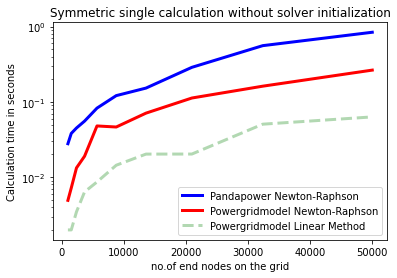

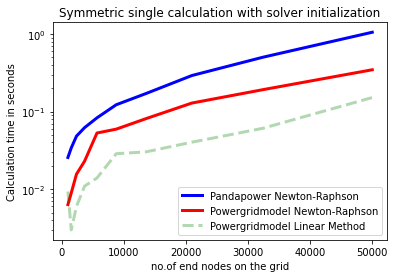

In [8]:
if Single_run:    
    # Visualization with pandapower
    if Pandapower_run:
        Visualization.get_versus_withpanda(n_node_list, PandaPower_NR_Symmetric_calculation_without_solver_initialization,
                                PGM_NR_Symmetric_calculation_without_solver_initialization,
                                PGM_Linear_Symmetric_calculation_without_solver_initialization,
                                'Symmetric single calculation without solver initialization')

        # display plot
        plt.show()



        Visualization.get_versus_withpanda(n_node_list, PandaPower_NR_Symmetric_calculation_with_solver_initialization,
                                PGM_NR_Symmetric_calculation_with_solver_initialization,
                                PGM_Linear_Symmetric_calculation_with_solver_initialization,
                                'Symmetric single calculation with solver initialization')

        # display plot
        plt.show()


    # Visualization without pandapower    
    else:
        Visualization.get_versus_withoutpanda(n_node_list, 
                                PGM_NR_Symmetric_calculation_without_solver_initialization,
                                PGM_Linear_Symmetric_calculation_without_solver_initialization,
                                'Symmetric single calculation without solver initialization')

        # display plot
        plt.show()



        Visualization.get_versus_withoutpanda(n_node_list, 
                                PGM_NR_Symmetric_calculation_with_solver_initialization,
                                PGM_Linear_Symmetric_calculation_with_solver_initialization,
                                'Symmetric single calculation with solver initialization')

        # display plot
        plt.show()



# Visualization for Asymmertic single calculation :

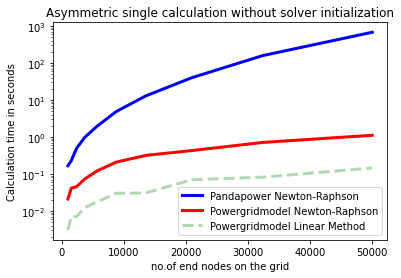

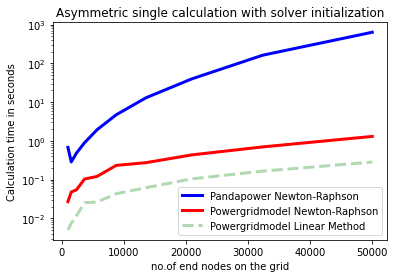

In [9]:
if Single_run:    
    # Visualization with pandapower
    if Pandapower_run:
            Visualization.get_versus_withpanda(n_node_list, PandaPower_NR_Asymmetric_calculation_without_solver_initialization,
                                    PGM_NR_Asymmetric_calculation_without_solver_initialization,
                                    PGM_Linear_Asymmetric_calculation_without_solver_initialization,
                                    'Asymmetric single calculation without solver initialization')

            # display plot
            plt.show()



            Visualization.get_versus_withpanda(n_node_list, PandaPower_NR_Asymmetric_calculation_with_solver_initialization,
                                    PGM_NR_Asymmetric_calculation_with_solver_initialization,
                                    PGM_Linear_Asymmetric_calculation_with_solver_initialization,
                                    'Asymmetric single calculation with solver initialization')

            # display plot
            plt.show()


    # Visualization without pandapower 
    else:
            Visualization.get_versus_withoutpanda(n_node_list, 
                                    PGM_NR_Asymmetric_calculation_without_solver_initialization,
                                    PGM_Linear_Asymmetric_calculation_without_solver_initialization,
                                    'Asymmetric single calculation without solver initialization')

            # display plot
            plt.show()



            Visualization.get_versus_withoutpanda(n_node_list, 
                                    PGM_NR_Asymmetric_calculation_with_solver_initialization,
                                    PGM_Linear_Asymmetric_calculation_with_solver_initialization,
                                    'Asymmetric single calculation with solver initialization')

            # display plot
            plt.show()


# Time Series Calculation

In [10]:
if Time_series_run:
    for i in range(len(n_feeder_node_list)):
        n_feeder = n_feeder_node_list[i]


        fictional_dataset = generate_fictional_grid(
            n_node_per_feeder=n_node_per_feeder,
            n_feeder=n_feeder,
            cable_length_km_min=cable_length_km_min,
            cable_length_km_max=cable_length_km_max,
            load_p_w_max=load_p_w_max,
            load_p_w_min=load_p_w_min,
            pf=pf
        )

        pp_net = fictional_dataset['pp_net']
        pgm_dataset = fictional_dataset['pgm_dataset']

        time_series_dataset = generate_time_series(
            fictional_dataset,
            n_step=n_step,
            load_scaling_min=load_scaling_min,
            load_scaling_max=load_scaling_max
        )

        pgm_update_dataset = time_series_dataset['pgm_update_dataset']
        pp_dataset = time_series_dataset['pp_dataset']
        time_steps = np.arange(n_step)

        for x, y in zip(['p', 'q'], ['mw', 'mvar']):
            for p in ['a', 'b', 'c']:
                name = f'{x}_{p}_{y}'
                pp.control.ConstControl(
                    pp_net,
                    element='asymmetric_load',
                    element_index=pp_net.asymmetric_load.index,
                    variable=name,
                    data_source=pp_dataset[name],
                    profile_name=pp_net.asymmetric_load.index
                )

# Symmetric

# Linear Method of power-grid-model



        pgm_model = pgm.PowerGridModel(pgm_dataset)
        start = time.time()
        pgm_result = pgm_model.calculate_power_flow(calculation_method='linear', update_data=pgm_update_dataset)
        end = time.time()
        PGM_Linear_Time_series_symmetric_calculation[i] = end - start
        #summary_df.loc['Time series symmetric calculation', 'PGM Linear'] = end - start
        

# Newton-Raphson Method of power-grid-model


        pgm_model = pgm.PowerGridModel(pgm_dataset)
        start = time.time()
        pgm_result = pgm_model.calculate_power_flow(update_data=pgm_update_dataset)
        end = time.time()
        PGM_NR_Time_series_symmetric_calculation[i] = end -start
        #summary_df.loc['Time series symmetric calculation', 'PGM NR'] = end - start
        

# Newton-Raphson Method of pandapower


        if Pandapower_run:
            pp.timeseries.OutputWriter(
                pp_net, output_path=output_dir, output_file_type=".csv", csv_separator=',',
                log_variables=[
                    ('res_bus', 'vm_pu'),
                    ('res_line', 'loading_percent'),
                ]
            )

            start = time.time()
            pp.timeseries.run_timeseries(
                pp_net, run=pp.runpp, time_steps=time_steps,
                calculate_voltage_angles=True, distributed_slack=True, lightsim2grid=use_lightsim2grid
            )
            end = time.time()
            PandaPower_NR_Time_series_symmetric_calculation[i] = end - start
            #summary_df.loc['Time series symmetric calculation', 'PandaPower NR'] = end - start
        

# Calculate Deviation for Newton-Raphson Method


        if Create_deviation_table:
            pp_u_pu = pd.read_csv(output_dir / 'res_bus' / 'vm_pu.csv', index_col=0).to_numpy()
            comparison_df.loc['Time series symmetric calculation', 'Deviation Voltage (p.u.)'] = np.abs(
                pp_u_pu - pgm_result['node']['u_pu']).max()
            pp_loading = pd.read_csv(output_dir / 'res_line' / 'loading_percent.csv', index_col=0).to_numpy() * 1e-2
            comparison_df.loc['Time series symmetric calculation', 'Deviation Loading (p.u.)'] = np.abs(
                pp_loading - pgm_result['line']['loading']).max()
            

# Asymmetric

# Linear Method of power-grid-model


        pgm_model = pgm.PowerGridModel(pgm_dataset)
        start = time.time()
        pgm_result = pgm_model.calculate_power_flow(symmetric=False, calculation_method='linear',
                                                    update_data=pgm_update_dataset)
        end = time.time()
        PGM_Linear_Time_series_asymmetric_calculation[i] = end -start
        #summary_df.loc['Time series asymmetric calculation', 'PGM Linear'] = end - start
        

# Newton-Raphson Method of power-grid-model


        pgm_model = pgm.PowerGridModel(pgm_dataset)
        start = time.time()
        pgm_result = pgm_model.calculate_power_flow(symmetric=False, update_data=pgm_update_dataset)
        end = time.time()
        PGM_NR_Time_series_asymmetric_calculation[i] = end - start
        #summary_df.loc['Time series asymmetric calculation', 'PGM NR'] = end - start
        

# Newton-Raphson Method of pandapower

 
        if Pandapower_run:
            del pp_net.output_writer
            ow = pp.timeseries.OutputWriter(pp_net, output_path=output_dir, output_file_type=".csv", csv_separator=',')
            ow.log_variable('res_bus_3ph', 'vm_a_pu', index=pp_net.bus.index)
            ow.log_variable('res_bus_3ph', 'vm_b_pu', index=pp_net.bus.index)
            ow.log_variable('res_bus_3ph', 'vm_c_pu', index=pp_net.bus.index)
            ow.log_variable('res_line_3ph', 'loading_percent', index=pp_net.line.index)

            # run
            start = time.time()
            pp.timeseries.run_timeseries(
                pp_net,
                run=pp.runpp_3ph,
                time_steps=time_steps,
                calculate_voltage_angles=True,
                distributed_slack=True,
                lightsim2grid=use_lightsim2grid
            )
            end = time.time()
            PandaPower_NR_Time_series_asymmetric_calculation[i] = end - start
            #summary_df.loc['Time series asymmetric calculation', 'PandaPower NR'] = end - start
            

# Calculate Deviation for Newton-Raphson Method


        if Create_deviation_table:
            pp_u_pu = []
            for p in ['a', 'b', 'c']:
                pp_u_pu.append(pd.read_csv(output_dir / 'res_bus_3ph' / f'vm_{p}_pu.csv', index_col=0).to_numpy())
            pp_u_pu = np.stack(pp_u_pu, axis=-1)
            comparison_df.loc['Time series asymmetric calculation', 'Deviation Voltage (p.u.)'] = np.abs(
                pp_u_pu - pgm_result['node']['u_pu']).max()
            pp_loading = pd.read_csv(output_dir / 'res_line_3ph' / 'loading_percent.csv', index_col=0).to_numpy() * 1e-2
            comparison_df.loc['Time series asymmetric calculation', 'Deviation Loading (p.u.)'] = np.abs(
                pp_loading - pgm_result['line']['loading']).max()


# Visualization for Symmertic Time-series calculation :

In [11]:
if Time_series_run:    
    # Visualization with pandapower 
    if Pandapower_run:

        Visualization.get_versus_withpanda(n_node_list, PandaPower_NR_Time_series_symmetric_calculation,
                                PGM_NR_Time_series_symmetric_calculation,
                                PGM_Linear_Time_series_symmetric_calculation,
                                'Symmetric Time-series calculation')
        # display plot
        plt.show()



    # Visualization without pandapower 
    else:

        Visualization.get_versus_withoutpanda(n_node_list,
                                PGM_NR_Time_series_symmetric_calculation,
                                PGM_Linear_Time_series_symmetric_calculation,
                                'Symmetric Time-series calculation')
        # display plot
        plt.show()





# Visualization for Asymmertic Time-series calculation :

In [12]:
if Time_series_run:    
    # Visualization with pandapower 
    if Pandapower_run:

        Visualization.get_versus_withpanda(n_node_list, PandaPower_NR_Time_series_asymmetric_calculation,
                                PGM_NR_Time_series_asymmetric_calculation,
                                PGM_Linear_Time_series_asymmetric_calculation,
                                'Asymmetric Time-series calculation')
        # display plot
        plt.show()



    # Visualization without pandapower 
    else:

        Visualization.get_versus_withoutpanda(n_node_list,
                                PGM_NR_Time_series_asymmetric_calculation,
                                PGM_Linear_Time_series_asymmetric_calculation,
                                'Asymmetric Time-series calculation')
        # display plot
        plt.show()




# N-1 Scenario Calculation

In [13]:
if N_1_run:

    for i in range(len(n_feeder_node_list)):
        n_feeder = n_feeder_node_list[i]
        n_node = n_node_per_feeder * n_feeder_node_list[i] + 1
        n_line = n_node_per_feeder * n_feeder_node_list[i]
        n_load = n_node_per_feeder * n_feeder_node_list[i]

        fictional_dataset = generate_fictional_grid(
            n_node_per_feeder=n_node_per_feeder,
            n_feeder=n_feeder,
            cable_length_km_min=cable_length_km_min,
            cable_length_km_max=cable_length_km_max,
            load_p_w_max=load_p_w_max,
            load_p_w_min=load_p_w_min,
            pf=pf
        )

        pp_net = fictional_dataset['pp_net']
        pgm_dataset = fictional_dataset['pgm_dataset']

        # update dataset for power grid model
        # disable one line per batch
        pgm_line_profile = pgm.initialize_array('update', 'line', (n_line, n_line))
        pgm_line_profile['id'] = pgm_dataset['line']['id']
        pgm_line_profile['from_status'] = 1
        pgm_line_profile['to_status'] = 1
        np.fill_diagonal(pgm_line_profile['from_status'], 0)
        np.fill_diagonal(pgm_line_profile['to_status'], 0)
        pgm_update_dataset = {'line': pgm_line_profile}
        

# Symmetric

# Linear Method of power-grid-model


        pgm_model = pgm.PowerGridModel(pgm_dataset)
        start = time.time()
        pgm_result = pgm_model.calculate_power_flow(calculation_method='linear', update_data=pgm_update_dataset)
        end = time.time()
        PGM_Linear_N_1_symmetric_calculation[i] = end - start
        #summary_df.loc['N-1 symmetric calculation', 'PGM Linear'] = end - start
        

# Newton-Raphson Method of power-grid-model


        pgm_model = pgm.PowerGridModel(pgm_dataset)
        start = time.time()
        pgm_result = pgm_model.calculate_power_flow(update_data=pgm_update_dataset)
        end = time.time()
        PGM_NR_N_1_symmetric_calculation[i] = end - start
        #summary_df.loc['N-1 symmetric calculation', 'PGM NR'] = end - start
        

# Newton-Raphson Method of pandapower


        # prepare pandapower result dataset
        if Pandapower_run:
            pp_u_pu = np.empty(shape=(n_line, n_node), dtype=np.float64)
            pp_loading = np.empty(shape=(n_line, n_line), dtype=np.float64)

            start = time.time()
            # loop to calcualte pandapower N-1
            for i in pp_net.line.index:
                # set one line out of service
                pp_net.line.loc[i, 'in_service'] = False
                pp.runpp(pp_net, algorithm='nr', calculate_voltage_angles=True, distributed_slack=True,
                         lightsim2grid=use_lightsim2grid)
                # restore that line
                pp_net.line.loc[i, 'in_service'] = True
                # get result
                pp_u_pu[i, :] = pp_net.res_bus['vm_pu']
                pp_loading[i, :] = pp_net.res_line['loading_percent'] * 1e-2
            end = time.time()
            PandaPower_NR_N_1_symmetric_calculation[i] = end - start
            #summary_df.loc['N-1 symmetric calculation', 'PandaPower NR'] = end - start

            # set nan to 0.0 to make a meaningful comparison
            pp_u_pu[np.isnan(pp_u_pu)] = 0.0
            pp_loading[np.isnan(pp_loading)] = 0.0
            

# Calculate Deviation for Newton-Raphson Method


        if Create_deviation_table:
            comparison_df.loc['N-1 symmetric calculation', 'Deviation Voltage (p.u.)'] = np.abs(
                pp_u_pu - pgm_result['node']['u_pu']).max()
            comparison_df.loc['N-1 symmetric calculation', 'Deviation Loading (p.u.)'] = np.abs(
                pp_loading - pgm_result['line']['loading']).max()
            
            

# Asymmetric

# Linear Method of power-grid-model


        pgm_model = pgm.PowerGridModel(pgm_dataset)
        start = time.time()
        pgm_result = pgm_model.calculate_power_flow(calculation_method='linear', update_data=pgm_update_dataset,
                                                    symmetric=False)
        end = time.time()
        PGM_Linear_N_1_asymmetric_calculation[i] = end -start
        #summary_df.loc['N-1 asymmetric calculation', 'PGM Linear'] = end - start
        

# Newton-Raphson Method of power-grid-model


        pgm_model = pgm.PowerGridModel(pgm_dataset)
        start = time.time()
        pgm_result = pgm_model.calculate_power_flow(update_data=pgm_update_dataset, symmetric=False)
        end = time.time()
        PGM_NR_N_1_asymmetric_calculation[i] = end - start
        #summary_df.loc['N-1 asymmetric calculation', 'PGM NR'] = end - start
        

# ### Newton-Raphson Method of pandapower

        if Pandapower_run:
            # get_ipython().run_cell_magic('capture', '', "\n
            # prepare pandapower result dataset\n
            pp_u_pu = np.empty(shape=(n_line, n_node, 3), dtype=np.float64)
            pp_loading = np.empty(shape=(n_line, n_line), dtype=np.float64)
            start = time.time()
            # loop to calcualte pandapower N-1\n
            for i in pp_net.line.index:
                # set one line out of service\n
                pp_net.line.loc[i, 'in_service'] = False
                pp.runpp_3ph(pp_net, algorithm='nr', calculate_voltage_angles=True, distributed_slack=True,
                             lightsim2grid=use_lightsim2grid)
                # restore that line\n
                pp_net.line.loc[i, 'in_service'] = True
                # get result\n
                pp_u_pu[i, ...] = pp_net.res_bus_3ph[['vm_a_pu', 'vm_b_pu', 'vm_c_pu']]
                pp_loading[i, :] = pp_net.res_line_3ph['loading_percent'] * 1e-2
            end = time.time()
            PandaPower_NR_N_1_asymmetric_calculation[i] = end - start
            #summary_df.loc['N-1 asymmetric calculation', 'PandaPower NR'] = end - start

            # set nan to 0.0 to make a meaningful comparison
            pp_u_pu[np.isnan(pp_u_pu)] = 0.0
            pp_loading[np.isnan(pp_loading)] = 0.0
            

# Calculate Deviation for Newton-Raphson Method


        if Create_deviation_table:
            comparison_df.loc['N-1 asymmetric calculation', 'Deviation Voltage (p.u.)'] = \
                np.abs(pp_u_pu - pgm_result['node']['u_pu']).max()
            comparison_df.loc['N-1 asymmetric calculation', 'Deviation Loading (p.u.)'] = \
                np.abs(pp_loading - pgm_result['line']['loading']).max()


# Visualization for Symmertic N-1 calculation :

In [14]:
if N_1_run:    
    # Visualization with pandapower 
    if Pandapower_run:

        Visualization.get_versus_withpanda(n_node_list, PandaPower_NR_N_1_symmetric_calculation,
                                           PGM_NR_N_1_symmetric_calculation,
                                           PGM_Linear_N_1_symmetric_calculation,
                                           'Symmetric N-1 calculation')
        # display plot
        plt.show()



    # Visualization without pandapower 
    else:

        Visualization.get_versus_withoutpanda(n_node_list,
                                              PGM_NR_N_1_symmetric_calculation,
                                              PGM_Linear_N_1_symmetric_calculation,
                                              'Symmetric N-1 calculation')
        # display plot
        plt.show()
 

# Visualization for Asymmertic N-1 calculation :

In [15]:
if N_1_run:    
    # Visualization with pandapower 
    if Pandapower_run:

        Visualization.get_versus_withpanda(n_node_list, PandaPower_NR_N_1_asymmetric_calculation,
                                           PGM_NR_N_1_asymmetric_calculation,
                                           PGM_Linear_N_1_asymmetric_calculation,
                                           'Asymmetric N-1 calculation')
        # display plot
        plt.show()



    # Visualization without pandapower 
    else:

        Visualization.get_versus_withoutpanda(n_node_list,
                                              PGM_NR_N_1_asymmetric_calculation,
                                              PGM_Linear_N_1_asymmetric_calculation,
                                              'Asymmetric N-1 calculation')
        # display plot
        plt.show()



# Summary

In [16]:
print('End Of Execution')

End Of Execution
